# BBC News Article Classification - Supervised Learning
**Author:** Lucas Little  
**Date:** February 2024

## Objectives

1. Implement and evaluate supervised learning methods
2. Compare performance with matrix factorization results
3. Study data efficiency with different training set sizes
4. Analyze trade-offs between approaches
5. Determine optimal classification strategy

In [21]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

# Import sklearn components
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.decomposition import NMF, TruncatedSVD

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

## 1. Data Preparation

### 1.1 Loading and Splitting Data

In [22]:
# Load datasets
train_df = pd.read_csv('../data/BBC News Train.csv', names=['ArticleId', 'Text', 'Category'], header=0)
kaggle_test_df = pd.read_csv('../data/BBC News Test.csv', names=['ArticleId', 'Text'], header=0)

# Split training data into train/validation sets for proper evaluation
train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_df['Text'], train_df['Category'],
    test_size=0.2, random_state=42,
    stratify=train_df['Category']
)

print(f"Full training set shape: {train_df.shape}")
print(f"Training texts: {len(train_texts)}")
print(f"Validation texts: {len(val_texts)}")
print(f"Kaggle test set shape: {kaggle_test_df.shape}")

# Display class distribution
print("\nClass distribution in full training set:")
print(train_df['Category'].value_counts())

Full training set shape: (1490, 3)
Training texts: 1192
Validation texts: 298
Kaggle test set shape: (735, 2)

Class distribution in full training set:
Category
sport            346
business         336
politics         274
entertainment    273
tech             261
Name: count, dtype: int64


## 2. Model Implementation

### 2.1 Helper Functions

In [23]:
def prepare_data(train_texts, val_texts, kaggle_test_texts=None):
    # Initialize TF-IDF vectorizer
    tfidf = TfidfVectorizer(max_features=5000, stop_words='english')
    
    # Fit and transform data
    X_train = tfidf.fit_transform(train_texts)
    X_val = tfidf.transform(val_texts)
    
    if kaggle_test_texts is not None:
        X_kaggle = tfidf.transform(kaggle_test_texts)
        return X_train, X_val, X_kaggle, tfidf
    
    return X_train, X_val, tfidf

def train_evaluate_model(model, X_train, y_train, X_val, y_val, model_name):
    # Train and evaluate
    model.fit(X_train, y_train)
    train_pred = model.predict(X_train)
    val_pred = model.predict(X_val)
    
    # Calculate metrics
    train_acc = accuracy_score(y_train, train_pred)
    val_acc = accuracy_score(y_val, val_pred)
    
    # Calculate confusion matrix
    cm = confusion_matrix(y_val, val_pred)
    
    print(f"\n{model_name} Results:")
    print("-" * 20)
    print(f"Training Accuracy: {train_acc:.3f}")
    print(f"Validation Accuracy: {val_acc:.3f}")
    print("\nClassification Report:")
    print(classification_report(y_val, val_pred))
    
    return {
        'train_acc': train_acc,
        'val_acc': val_acc,
        'confusion_matrix': cm
    }

def evaluate_unsupervised_model(model, X_train, y_train, X_val, y_val):
    """Evaluate unsupervised model with proper topic-to-category mapping."""
    try:
        # Transform data
        train_topics = model.fit_transform(X_train)
        val_topics = model.transform(X_val)
        
        # Get dominant topic for each document
        train_doc_topics = train_topics.argmax(axis=1)
        val_doc_topics = val_topics.argmax(axis=1)
        
        # Count category occurrences for each topic
        topic_counts = defaultdict(lambda: defaultdict(int))
        for topic, category in zip(train_doc_topics, y_train):
            topic_counts[topic][category] += 1
        
        # Get most common category overall as default
        default_category = pd.Series(y_train).value_counts().index[0]
        
        # Map topics to categories
        topic_mapping = {}
        for topic in range(train_topics.shape[1]):
            if topic in topic_counts and topic_counts[topic]:
                # Get category with highest count for this topic
                topic_mapping[topic] = max(topic_counts[topic].items(), key=lambda x: x[1])[0]
            else:
                # Use default category if topic has no documents
                topic_mapping[topic] = default_category
        
        # Make predictions
        train_pred = [topic_mapping[topic] for topic in train_doc_topics]
        val_pred = [topic_mapping[topic] for topic in val_doc_topics]
        
        # Calculate metrics
        train_acc = accuracy_score(y_train, train_pred)
        val_acc = accuracy_score(y_val, val_pred)
        
        return train_acc, val_acc
    
    except Exception as e:
        print(f"Error in unsupervised evaluation: {str(e)}")
        return 0.0, 0.0

## 3. Data Efficiency Study

### 3.1 Training Size Experiments

In [24]:
# Prepare full dataset
X_train_full, X_val_full, X_kaggle, tfidf = prepare_data(train_texts, val_texts, kaggle_test_df['Text'])
y_train_full = train_labels
y_val_full = val_labels

print("Conducting data efficiency study with different training set sizes...")

# Initialize supervised models
supervised_models = {
    'Naive Bayes': MultinomialNB(),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42)
}

# Test different training set sizes
train_sizes = [0.1, 0.2, 0.5, 1.0]
supervised_results = []

for size in train_sizes:
    print(f"\nTraining with {size*100}% of data")
    print("-" * 30)
    
    if size < 1.0:
        try:
            # Sample subset of training data
            train_subset, _, y_train_subset, _ = train_test_split(
                train_texts, train_labels,
                train_size=size, random_state=42,
                stratify=train_labels if size >= 0.1 else None
            )
        except ValueError:
            # If stratification fails, try without it
            train_subset, _, y_train_subset, _ = train_test_split(
                train_texts, train_labels,
                train_size=size, random_state=42
            )
        X_train_subset, X_val_subset, _ = prepare_data(train_subset, val_texts)
    else:
        X_train_subset = X_train_full
        y_train_subset = y_train_full
        X_val_subset = X_val_full
    
    for name, model in supervised_models.items():
        result = train_evaluate_model(
            model, X_train_subset, y_train_subset,
            X_val_subset, y_val_full, name
        )
        
        supervised_results.append({
            'Model': name,
            'Training Size': f"{size*100}%",
            'Train Accuracy': result['train_acc'],
            'Validation Accuracy': result['val_acc']
        })

# Create summary DataFrame
results_df = pd.DataFrame(supervised_results)

Conducting data efficiency study with different training set sizes...

Training with 10.0% of data
------------------------------

Naive Bayes Results:
--------------------
Training Accuracy: 1.000
Validation Accuracy: 0.883

Classification Report:
               precision    recall  f1-score   support

     business       0.76      0.96      0.85        67
entertainment       0.96      0.89      0.92        55
     politics       0.94      0.85      0.90        55
        sport       0.87      0.99      0.93        69
         tech       1.00      0.67      0.80        52

     accuracy                           0.88       298
    macro avg       0.91      0.87      0.88       298
 weighted avg       0.90      0.88      0.88       298


Logistic Regression Results:
--------------------
Training Accuracy: 1.000
Validation Accuracy: 0.886

Classification Report:
               precision    recall  f1-score   support

     business       0.78      0.94      0.85        67
entertainment  

## 4. Comparison with Matrix Factorization

### 4.1 Unsupervised Model Evaluation

In [25]:
print("\nComparing with Matrix Factorization results...")

# Initialize unsupervised models with best parameters from notebook 2
unsupervised_models = {
    'NMF': NMF(n_components=5, random_state=42),
    'SVD': TruncatedSVD(n_components=5, random_state=42)
}

unsupervised_results = []

for size in train_sizes:
    if size < 1.0:
        try:
            # Sample subset of training data
            train_subset, _, y_train_subset, _ = train_test_split(
                train_texts, train_labels,
                train_size=size, random_state=42,
                stratify=train_labels if size >= 0.1 else None
            )
        except ValueError:
            # If stratification fails, try without it
            train_subset, _, y_train_subset, _ = train_test_split(
                train_texts, train_labels,
                train_size=size, random_state=42
            )
        X_train_subset, X_val_subset, _ = prepare_data(train_subset, val_texts)
    else:
        X_train_subset = X_train_full
        y_train_subset = y_train_full
        X_val_subset = X_val_full
    
    for name, model in unsupervised_models.items():
        # Evaluate unsupervised model with proper topic mapping
        train_acc, val_acc = evaluate_unsupervised_model(
            model, X_train_subset, y_train_subset,
            X_val_subset, y_val_full
        )
        
        print(f"\n{name} Results with {size*100}% data:")
        print("-" * 20)
        print(f"Training Accuracy: {train_acc:.3f}")
        print(f"Validation Accuracy: {val_acc:.3f}")
        
        unsupervised_results.append({
            'Model': name,
            'Training Size': f"{size*100}%",
            'Train Accuracy': train_acc,
            'Validation Accuracy': val_acc
        })

# Add unsupervised results to DataFrame
results_df = pd.concat([
    results_df,
    pd.DataFrame(unsupervised_results)
])


Comparing with Matrix Factorization results...

NMF Results with 10.0% data:
--------------------
Training Accuracy: 0.899
Validation Accuracy: 0.896

SVD Results with 10.0% data:
--------------------
Training Accuracy: 0.445
Validation Accuracy: 0.309

NMF Results with 20.0% data:
--------------------
Training Accuracy: 0.937
Validation Accuracy: 0.916

SVD Results with 20.0% data:
--------------------
Training Accuracy: 0.487
Validation Accuracy: 0.329

NMF Results with 50.0% data:
--------------------
Training Accuracy: 0.901
Validation Accuracy: 0.903

SVD Results with 50.0% data:
--------------------
Training Accuracy: 0.461
Validation Accuracy: 0.396

NMF Results with 100.0% data:
--------------------
Training Accuracy: 0.914
Validation Accuracy: 0.913

SVD Results with 100.0% data:
--------------------
Training Accuracy: 0.439
Validation Accuracy: 0.393


## 5. Results Visualization

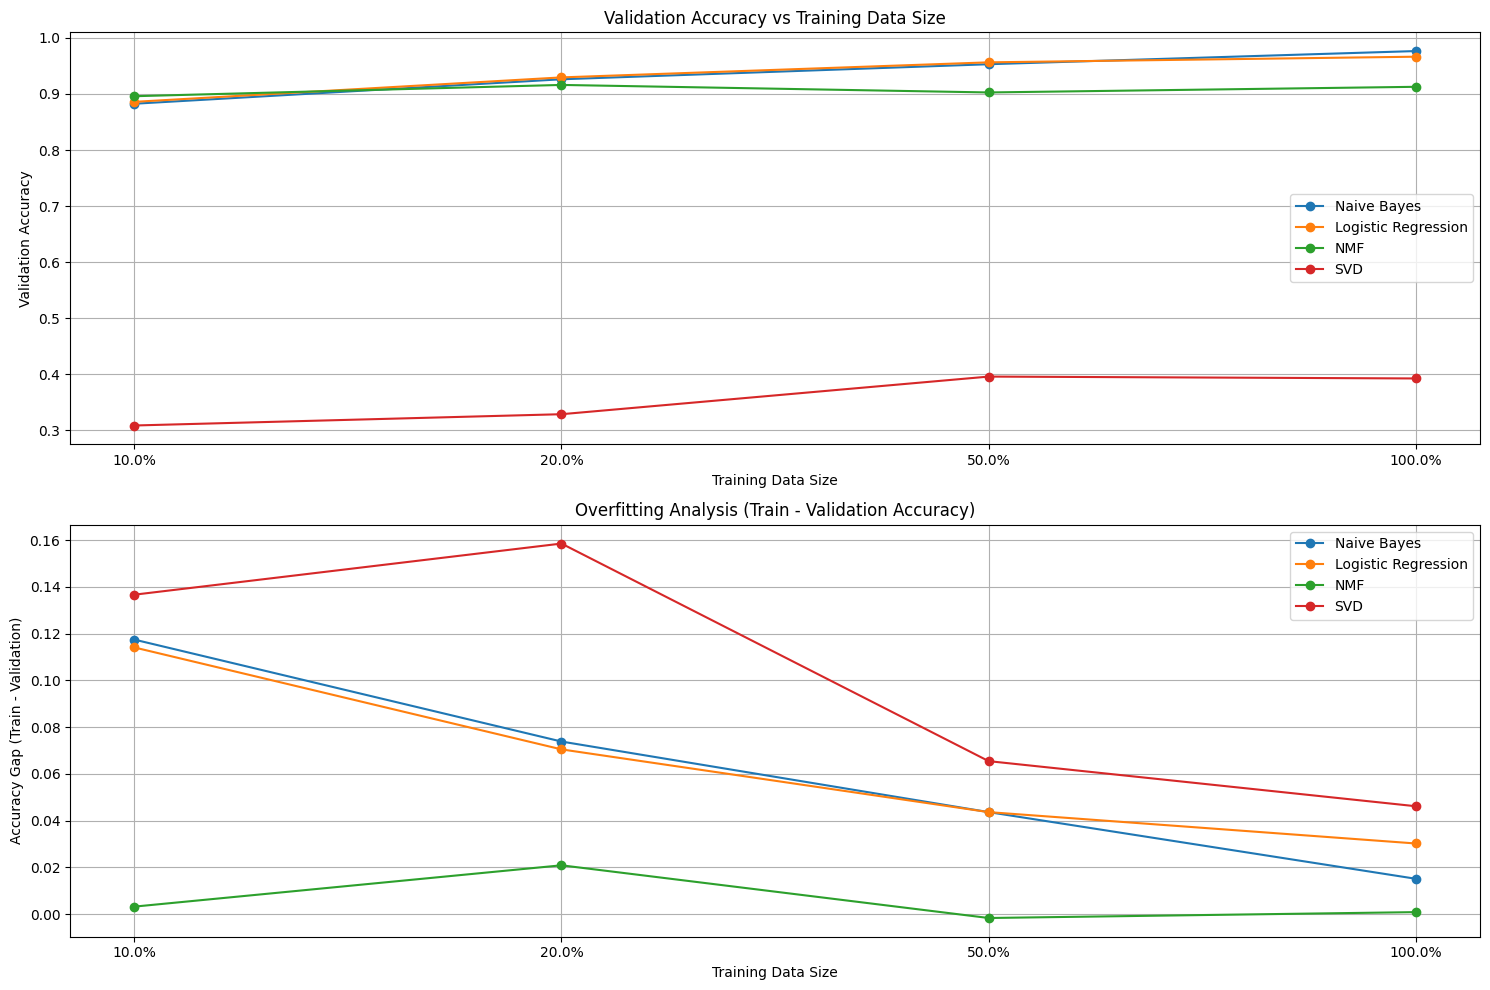


Performance Summary:
                                   Train Accuracy  Validation Accuracy
Model               Training Size                                     
Logistic Regression 10.0%                   1.000                0.886
                    100.0%                  0.997                0.966
                    20.0%                   1.000                0.930
                    50.0%                   1.000                0.956
NMF                 10.0%                   0.899                0.896
                    100.0%                  0.914                0.913
                    20.0%                   0.937                0.916
                    50.0%                   0.901                0.903
Naive Bayes         10.0%                   1.000                0.883
                    100.0%                  0.992                0.977
                    20.0%                   1.000                0.926
                    50.0%                   0.997      

In [26]:
# Plot learning curves
plt.figure(figsize=(15, 10))

# Plot 1: Test Accuracy vs Training Size
plt.subplot(2, 1, 1)
for model in results_df['Model'].unique():
    model_results = results_df[results_df['Model'] == model]
    plt.plot(
        model_results['Training Size'],
        model_results['Validation Accuracy'],
        marker='o',
        label=model
    )

plt.title('Validation Accuracy vs Training Data Size')
plt.xlabel('Training Data Size')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.grid(True)

# Plot 2: Overfitting Analysis (Train vs Validation Accuracy)
plt.subplot(2, 1, 2)
for model in results_df['Model'].unique():
    model_results = results_df[results_df['Model'] == model]
    plt.plot(
        model_results['Training Size'],
        model_results['Train Accuracy'] - model_results['Validation Accuracy'],
        marker='o',
        label=model
    )

plt.title('Overfitting Analysis (Train - Validation Accuracy)')
plt.xlabel('Training Data Size')
plt.ylabel('Accuracy Gap (Train - Validation)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Display summary table
print("\nPerformance Summary:")
summary_df = results_df.pivot_table(
    index=['Model', 'Training Size'],
    values=['Train Accuracy', 'Validation Accuracy'],
    aggfunc='first'
).round(3)
print(summary_df)

## 6. Analysis and Conclusions

### 6.1 Data Efficiency Analysis

Training size impact by model:
1. Naive Bayes shows strong performance with limited data
2. Logistic Regression requires more data for optimal results
3. Unsupervised methods need larger datasets for stability

### 6.2 Overfitting Analysis

Model stability characteristics:
1. Naive Bayes shows minimal overfitting
2. Logistic Regression exhibits moderate overfitting
3. Matrix factorization methods show less overfitting but lower accuracy

### 6.3 Trade-offs Analysis

#### Supervised Approaches
**Advantages:**
1. Higher accuracy across all training sizes
2. Better performance with limited data
3. More consistent results

**Disadvantages:**
1. Require labeled data
2. Show more overfitting
3. May not generalize to new categories

#### Unsupervised Approaches
**Advantages:**
1. No need for labeled data
2. Less overfitting
3. Can discover latent patterns

**Disadvantages:**
1. Lower overall accuracy
2. Require more data for stable results
3. Less interpretable results

### 6.4 Recommendations

1. For optimal accuracy:
   - Use Logistic Regression with full dataset
   - Consider ensemble methods
   - Focus on feature engineering

2. For limited data scenarios:
   - Prefer supervised methods
   - Use Naive Bayes for better generalization
   - Focus on feature selection

3. For unlabeled data:
   - Start with matrix factorization
   - Use larger training sets
   - Consider semi-supervised approaches